# Factor Allocation Strategy

**Point-in-Time FRED-MD** macroeconomic data to predict factor allocation.

**Model**: MICRO Transformer (12k params)

## Rigorous Evaluation Methodology

```
┌─────────────────────────────────────────────────────────────────┐
│ STEP 1: WALK-FORWARD (2017-2021)                                │
│   - Train N models on expanding windows                         │
│   - Test each on 1 year OOS (non-overlapping)                   │
│   - HOLDOUT: 2022-2024 reserved (no model sees these)           │
│   - Save all N models for WF ensemble                           │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│ STEP 2: FINAL MODEL                                             │
│   - Train on 2000-2021 (all data except holdout)                │
│   - Single model (seed=999) for production use                  │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│ STEP 3: HOLDOUT EVALUATION (2022-2024)                          │
│   - Train FAIR ENSEMBLE (5 models, same data, diff seeds)       │
│   - Evaluate: Final vs Fair Ensemble vs WF Ensemble             │
│   - Fair comparison: Final vs Fair Ensemble (same data)         │
│   - Data bias: Fair Ensemble vs WF Ensemble (different data)    │
└─────────────────────────────────────────────────────────────────┘
```

### Why Fair Ensemble?

| Comparison | What it measures |
|------------|------------------|
| Final vs Fair Ensemble | Pure ensemble effect (same data, different seeds) |
| Fair vs WF Ensemble | Data quantity bias (different training periods) |

## Analysis Axes (up to 96 combinations)

| Axis | Options | Description |
|------|---------|-------------|
| **Strategy** | E2E, E2E-P3, Supervised | Training methodology (E2E-P3 = Phase 3 only) |
| **Allocation** | Binary (2F), Multi (6F) | Number of factors |
| **Horizon** | 1M, 3M, 6M, 12M | Sharpe optimization target |
| **Config** | baseline, fs, hpt, fs+hpt | Feature Selection / HP Tuning |

### Config Options

| Config | Feature Selection | HP Tuning | Description |
|--------|-------------------|-----------|-------------|
| `baseline` | OFF | OFF | Default (112 features, fixed HP) |
| `fs` | ON | OFF | Reduce to top N features |
| `hpt` | OFF | ON | Tune HP on full features |
| `fs+hpt` | ON | ON | Tune HP on selected features |

**Note**: HP tuning is independent per config (hpt tunes on 112 features, fs+hpt tunes on N selected features).

**Key**: All models rebalance monthly. Horizon = Sharpe optimization target.

In [1]:
# ============================================================
# IMPORTS & RELOAD (Run this cell to reload all modules)
# ============================================================
# This cell imports all modules used in this notebook and provides
# a reload_all() function to refresh them after code changes.

%matplotlib inline

import sys
import warnings
import importlib
from pathlib import Path

warnings.filterwarnings('ignore')

# Setup project path
project_root = Path.cwd().parent
if str(project_root / "src") not in sys.path:
    sys.path.insert(0, str(project_root / "src"))

# ============================================================
# Standard library imports
# ============================================================
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# ============================================================
# Project module imports (with reload support)
# ============================================================

# Data loaders
import data.point_in_time_loader
import data.factor_data_loader
import data.data_loader

from data.point_in_time_loader import PointInTimeFREDMDLoader, PointInTimeConfig
from data.factor_data_loader import FactorDataLoader, FactorDataConfig
from data.data_loader import Region

# Feature engineering
import features.feature_engineering
import features.feature_selection

from features.feature_engineering import FeatureEngineer, FeatureConfig
from features.feature_selection import (
    IndicatorSelector,
    PCAFeatureReducer,
    SelectionConfig,
    PCAConfig,
)

# Comparison runner
import comparison_runner
from comparison_runner import (
    prepare_data,
    run_combination_walk_forward,
    train_final_model,
    train_fair_ensemble_models,
    evaluate_on_holdout,
    ensemble_predict,
    compute_composite_score,
)

# Pipelines
import pipelines
import pipelines.three_step_pipeline
from pipelines import ThreeStepEvaluation
from pipelines.three_step_pipeline import EvaluationConfig

# Visualization
import visualization
import visualization.walk_forward_plots
import visualization.holdout_plots
import visualization.colormaps

from visualization import plot_all_walk_forward, plot_all_holdout

# Utilities
import utils.metrics
import utils.benchmarks
import utils.walk_forward
import utils.keys
import utils.constants
import utils.analysis
import utils.statistics

from utils.benchmarks import compute_all_benchmarks
from utils.metrics import compute_total_return, compute_max_drawdown
from utils.keys import unpack_key
from utils.analysis import (
    print_best_models_table,
    print_model_comparison_summary,
    print_statistical_analysis,
)

# ============================================================
# RELOAD FUNCTION
# ============================================================

def reload_all():
    """
    Reload all project modules.
    
    Call this function after modifying source code to pick up changes
    without restarting the kernel.
    
    Usage:
        reload_all()
    """
    modules_to_reload = [
        # Data (order matters: base modules first)
        data.data_loader,
        data.point_in_time_loader,
        data.factor_data_loader,
        # Features
        features.feature_engineering,
        features.feature_selection,
        # Utils
        utils.metrics,
        utils.walk_forward,
        utils.benchmarks,
        utils.keys,
        utils.constants,
        utils.analysis,
        utils.statistics,
        # Core
        comparison_runner,
        # Visualization
        visualization.colormaps,
        visualization.walk_forward_plots,
        visualization.holdout_plots,
        visualization,
        # Pipelines
        pipelines.three_step_pipeline,
        pipelines,
    ]
    
    for module in modules_to_reload:
        try:
            importlib.reload(module)
        except Exception as e:
            print(f"Warning: Could not reload {module.__name__}: {e}")
    
    # Re-import key functions after reload
    global PointInTimeFREDMDLoader, PointInTimeConfig
    global FactorDataLoader, FactorDataConfig, Region
    global FeatureEngineer, FeatureConfig
    global IndicatorSelector, PCAFeatureReducer, SelectionConfig, PCAConfig
    global prepare_data, compute_composite_score
    global ThreeStepEvaluation, EvaluationConfig
    global plot_all_walk_forward, plot_all_holdout
    global compute_all_benchmarks
    global unpack_key, print_best_models_table, print_model_comparison_summary
    global print_statistical_analysis
    
    from data.point_in_time_loader import PointInTimeFREDMDLoader, PointInTimeConfig
    from data.factor_data_loader import FactorDataLoader, FactorDataConfig
    from data.data_loader import Region
    from features.feature_engineering import FeatureEngineer, FeatureConfig
    from features.feature_selection import IndicatorSelector, PCAFeatureReducer, SelectionConfig, PCAConfig
    from comparison_runner import prepare_data, compute_composite_score
    from pipelines import ThreeStepEvaluation
    from pipelines.three_step_pipeline import EvaluationConfig
    from visualization import plot_all_walk_forward, plot_all_holdout
    from utils.benchmarks import compute_all_benchmarks
    from utils.keys import unpack_key
    from utils.analysis import (
        print_best_models_table,
        print_model_comparison_summary,
        print_statistical_analysis,
    )
    
    print("All modules reloaded successfully!")

# ============================================================
# Set random seeds for reproducibility
# ============================================================
np.random.seed(42)
torch.manual_seed(42)

print("Imports complete. Use reload_all() to refresh modules after code changes.")

Imports complete. Use reload_all() to refresh modules after code changes.


In [2]:
# ============================================================
# SETUP (simplified - imports are in the cell above)
# ============================================================

# This cell is kept for compatibility but imports are now centralized above.
# Just verify setup is complete.

print(f"Project root: {project_root}")
print(f"NumPy: {np.__version__}, Pandas: {pd.__version__}, PyTorch: {torch.__version__}")
print("Setup complete")

Project root: /Users/mathis/Finance-Quant-thinking/Strategies/factor_allocation_strategy_macro
NumPy: 2.4.1, Pandas: 2.3.3, PyTorch: 2.10.0
Setup complete


In [3]:
# ============================================================
# DATA LOADING
# ============================================================

# Load Point-in-Time FRED-MD
vintages_dir = project_root / "data_cache" / "vintages"

pit_loader = PointInTimeFREDMDLoader(
    PointInTimeConfig(
        vintages_dir=vintages_dir,
        publication_lag=1,
        apply_transformations=True
    )
)

macro_data = pit_loader.create_pit_macro_dataframe(
    start_date="2000-01-01",
    end_date="2024-12-31"
)

market_data = pit_loader.create_pit_market_context(
    start_date="2000-01-01",
    end_date="2024-12-31"
)

indicators = pit_loader.get_indicators()

# Load factor returns
factor_loader = FactorDataLoader(
    FactorDataConfig(
        start_date="2000-01-01",
        end_date="2024-12-31",
        cache_dir=project_root / "data_cache" / "factors",
        use_cache=True
    )
)

factor_data = factor_loader.load_all_factors()

print(f"\nData loaded: {len(macro_data)} macro obs, {len(factor_data)} factor obs")

Indexed 305 vintage files
  Coverage: 1999-08 to 2024-12
Loading cached all factors from /Users/mathis/Finance-Quant-thinking/Strategies/factor_allocation_strategy_macro/data_cache/factors/all_factors.parquet

Data loaded: 32799 macro obs, 288 factor obs


---
## Model Configuration

In [4]:
# ============================================================
# CONFIGURATION
# ============================================================

# MICRO Transformer (12k params) with enhanced regularization
CONFIG = {
    # Architecture
    "sequence_length": 12,
    "num_factors": 6,
    "d_model": 32,
    "num_heads": 1,
    "num_layers": 1,
    "d_ff": 64,
    "dropout": 0.75,          # Increased from 0.6
    
    # Training (enhanced regularization)
    "learning_rate": 0.0005,  # Reduced from 0.001
    "batch_size": 64,         # Increased from 32
    "weight_decay": 0.05,     # Increased from 0.02
    "epochs_phase1": 20,
    "epochs_phase2": 15,
    "epochs_phase3": 15,
    
    # Backtest
    "execution_threshold": 0.05,
    "transaction_cost": 0.001,
    "val_split": 0.2,
    
    # Early stopping
    "early_stopping": True,
    "early_stopping_patience": 5,
}

# Feature engineering
feature_config = FeatureConfig(
    sequence_length=12,
    include_momentum=True,
    include_market_context=True,
    use_fred_md=True,
    aggregation_windows=[1, 3, 6, 12]
)

feature_engineer = FeatureEngineer(
    config=feature_config,
    region=Region.US,
    fred_md_indicators=indicators
)

print(f"Model: d_model={CONFIG['d_model']}, layers={CONFIG['num_layers']}, heads={CONFIG['num_heads']}")
print(f"Regularization: dropout={CONFIG['dropout']}, weight_decay={CONFIG['weight_decay']}, batch_size={CONFIG['batch_size']}")
print(f"Features: {feature_engineer.get_num_indicators()} indicators")

Model: d_model=32, layers=1, heads=1
Regularization: dropout=0.75, weight_decay=0.05, batch_size=64
Features: 112 indicators


---
## Feature Selection & PCA (Optional)

Reduce dimensionality from 112 indicators to improve generalization.

In [5]:
# ============================================================
# FEATURE SELECTION & PCA DEMO
# ============================================================

# Create target data for 1M horizon
target_1m = factor_loader.create_binary_target(factor_data, horizon_months=1)

# --- OPTION 1: Indicator Selection (Mutual Information) ---
print("=" * 60)
print("INDICATOR SELECTION (Mutual Information)")
print("=" * 60)

selector = feature_engineer.create_indicator_selector(
    macro_data=macro_data,
    target_data=target_1m,
    method="mutual_info",
    n_features=30,  # Keep top 30 indicators
)

# Show top indicators
rankings = selector.get_indicator_rankings()
print(f"\nTop 10 indicators (out of {len(rankings)}):")
print(rankings.head(10).to_string(index=False))

# Apply selection
macro_filtered = feature_engineer.apply_indicator_selection(macro_data, selector)
print(f"\nFiltered: {len(macro_data)} -> {len(macro_filtered)} observations")
print(f"Unique indicators: {macro_data['indicator'].nunique()} -> {macro_filtered['indicator'].nunique()}")

# --- OPTION 2: PCA on Flat Features ---
print("\n" + "=" * 60)
print("PCA DIMENSIONALITY REDUCTION")
print("=" * 60)

pca_reducer = feature_engineer.create_pca_reducer(
    macro_data=macro_data,
    factor_data=factor_data,
    market_data=market_data,
    target_data=target_1m,
    n_components=20,  # Keep 20 components
)

variance_ratio, total_var = pca_reducer.get_explained_variance()
print(f"\nPCA: {len(variance_ratio)} components -> {total_var:.1%} variance explained")
print(f"Top 5 components: {variance_ratio[:5].round(3)}")

# Example: Get PCA-reduced features for one date
sample_date = target_1m.iloc[100]["timestamp"]
pca_features = feature_engineer.create_flat_features_with_pca(
    macro_data, factor_data, market_data, sample_date, pca_reducer
)
print(f"\nExample: date={sample_date.date()}")
print(f"  Original features: ~100 -> PCA features: {len(pca_features)}")


Created binary targets: 287 observations
Target distribution:
target
1    149
0    138
Name: count, dtype: int64
INDICATOR SELECTION (Mutual Information)

Top 10 indicators (out of 112):
indicator    score  selected  rank
 DTCTHFNM 0.087417      True     1
 BUSLOANS 0.072862      True     2
  EXUSUKx 0.067725      True     3
  EXSZUSx 0.066074      True     4
  W875RX1 0.065866      True     5
   PPIFCG 0.056743      True     6
  AWOTMAN 0.053020      True     7
 UMCSENTx 0.046829      True     8
  VXOCLSx 0.045741      True     9
   MANEMP 0.040656      True    10

Filtered: 32799 -> 8743 observations
Unique indicators: 112 -> 30

PCA DIMENSIONALITY REDUCTION

PCA: 20 components -> 87.7% variance explained
Top 5 components: [0.138 0.114 0.074 0.065 0.061]

Example: date=2008-05-01
  Original features: ~100 -> PCA features: 20


---
## Walk-Forward Hyperparameter Tuning (Optional)

Tune hyperparameters **before training** using walk-forward validation:
- Respects temporal order (no look-ahead bias)
- Uses Bayesian optimization (Optuna) or random search
- Optimizes validation Sharpe ratio

If enabled, tuned parameters will be used for the 24-combination training below.

In [6]:
# ============================================================
# CONFIGURATION: ANALYSIS AXES (FS / HPT)
# ============================================================
# Control which configs to run:
# - baseline: No feature selection, no HP tuning (default)
# - fs: Feature Selection only (reduce 112 -> N indicators)
# - hpt: HP Tuning only (tune hyperparameters via walk-forward)
# - fs+hpt: Both Feature Selection AND HP Tuning

# Enable/disable analysis axes
USE_FEATURE_SELECTION = False  # Set True to add "fs" config
USE_HP_TUNING = False          # Set True to add "hpt" config

# Build configs_to_run based on flags
CONFIGS_TO_RUN = ["baseline"]
if USE_FEATURE_SELECTION and USE_HP_TUNING:
    CONFIGS_TO_RUN = ["baseline", "fs", "hpt", "fs+hpt"]  # 64 combinations
elif USE_FEATURE_SELECTION:
    CONFIGS_TO_RUN = ["baseline", "fs"]  # 32 combinations
elif USE_HP_TUNING:
    CONFIGS_TO_RUN = ["baseline", "hpt"]  # 32 combinations

# Feature selection settings (if enabled)
N_FEATURES = 30                # Number of indicators to keep
SELECTION_METHOD = "mutual_info"  # "mutual_info" or "f_classif"

# HP tuning settings (if enabled)
HP_TUNING_TRIALS = 15          # Number of Optuna trials per config

# Prepare target data
targets, cumulative_returns = prepare_data(factor_loader, factor_data)

# Use CONFIG as base (can be tuned later if HP tuning enabled at precompute stage)
TUNED_CONFIG = CONFIG.copy()

# Summary
n_base = 3 * 2 * 4  # 3 strategies × 2 allocations × 4 horizons
n_configs = len(CONFIGS_TO_RUN)
print(f"Analysis axes configuration:")
print(f"  Feature Selection: {'ON' if USE_FEATURE_SELECTION else 'OFF'} (n_features={N_FEATURES})")
print(f"  HP Tuning: {'ON' if USE_HP_TUNING else 'OFF'} (trials={HP_TUNING_TRIALS})")
print(f"  Configs to run: {CONFIGS_TO_RUN}")
print(f"  Total combinations: {n_base} base × {n_configs} configs = {n_base * n_configs}")


Horizon 1M: 287 observations
  Target distribution: {1: np.int64(149), 0: np.int64(138)}

Horizon 3M: 285 observations
  Target distribution: {1: np.int64(154), 0: np.int64(131)}

Horizon 6M: 282 observations
  Target distribution: {1: np.int64(144), 0: np.int64(138)}

Horizon 12M: 276 observations
  Target distribution: {1: np.int64(139), 0: np.int64(137)}
Analysis axes configuration:
  Feature Selection: OFF (n_features=30)
  HP Tuning: OFF (trials=15)
  Configs to run: ['baseline']
  Total combinations: 24 base × 1 configs = 24


---
## STEP 1: Walk-Forward Validation (with Holdout)

**Proper OOS evaluation with 2-year holdout:**
- Train N models on expanding windows (2000-2013 -> 2000-2020)
- Test each on 1 year OOS (2017, 2018, ..., 2022)
- **HOLDOUT 2023-2024**: No model sees these years during training
- Save all N models for ensemble comparison

This gives us TRUE out-of-sample metrics for 2017-2022.

In [7]:
# ============================================================
# STEP 1: WALK-FORWARD WITH HOLDOUT
# ============================================================

# Configuration for evaluation (uses CONFIGS_TO_RUN from cell above)
eval_config = EvaluationConfig(
    holdout_years=3,
    holdout_start_date="2022-01-01",
    horizons=[1, 3, 6, 12],
    save_models=True,
    verbose=True,
    # Fair Ensemble configuration (eliminates data quantity bias)
    train_fair_ensemble=True,  # Train 5 models on same data with different seeds
    fair_ensemble_n_models=5,
    fair_ensemble_base_seed=42,
    fair_ensemble_seed_step=100,
    # Bias analysis (optional - set True to decompose effects)
    run_bias_analysis=False,
    bias_cutoff_years=[2014, 2017, 2020],
    # FS/HPT analysis axes (from cell above)
    configs_to_run=CONFIGS_TO_RUN,
    n_features=N_FEATURES,
    selection_method=SELECTION_METHOD,
    hp_tuning_trials=HP_TUNING_TRIALS,
)

# Create evaluator
evaluator = ThreeStepEvaluation(
    macro_data=macro_data,
    factor_data=factor_data,
    market_data=market_data,
    indicators=indicators,
    feature_engineer=feature_engineer,
    model_config=TUNED_CONFIG,
    factor_loader=factor_loader,
    eval_config=eval_config,
)

# Run Step 1: Walk-forward validation
evaluator.run_step1_walk_forward()
all_wf_results = evaluator.wf_results

# Print walk-forward summary
wf_summary = evaluator._build_walk_forward_summary()
print("\n" + "=" * 90)
print("WALK-FORWARD SUMMARY (2017-2021)")
print("=" * 90)
print(f"\n{'Strategy':<8} {'Alloc':<7} {'H':<4} {'Config':<10} {'OOS Sharpe':>11} {'IC':>8} {'MaxDD':>9} {'Score':>8} {'Rank':>6}")
print("-" * 90)
for _, row in wf_summary.iterrows():
    config_name = row.get('config', 'baseline')
    print(f"{row['strategy']:<8} {row['allocation']:<7} {row['horizon']}M{'':<2} {config_name:<10} "
          f"{row['true_oos_sharpe']:>+11.4f} {row['avg_ic']:>+8.4f} "
          f"{row['true_oos_maxdd']:>+9.4f} {row['score']:>8.4f} {int(row['rank']):>6}")

best = wf_summary.iloc[0]
print("-" * 90)
print(f"\nBEST: {best['strategy']} + {best['allocation']} @ {best['horizon']}M [{best.get('config', 'baseline')}] "
      f"-> Score={best['score']:.4f}")


Horizon 1M: 287 observations
  Target distribution: {1: np.int64(149), 0: np.int64(138)}

Horizon 3M: 285 observations
  Target distribution: {1: np.int64(154), 0: np.int64(131)}

Horizon 6M: 282 observations
  Target distribution: {1: np.int64(144), 0: np.int64(138)}

Horizon 12M: 276 observations
  Target distribution: {1: np.int64(139), 0: np.int64(137)}
PRECOMPUTING CONFIGS
Configs to run: ['baseline']

Precomputed 1 configs: ['baseline']
STEP 1: WALK-FORWARD VALIDATION
Holdout: 2022-01-01 onwards (FIXED for all horizons)
Configs: ['baseline']
Running 24 combinations (24 base × 1 configs)...


--- Config: baseline ---

[1/24] E2E + Binary @ 1M [baseline]
  Avg Sharpe: +1.7829, Avg IC: -0.2477, Models saved: 5

[2/24] E2E + Binary @ 3M [baseline]
  Avg Sharpe: +1.7195, Avg IC: -0.2039, Models saved: 5

[3/24] E2E + Binary @ 6M [baseline]
  Avg Sharpe: +1.6360, Avg IC: -0.1117, Models saved: 5

[4/24] E2E + Binary @ 12M [baseline]
  Avg Sharpe: +1.6351, Avg IC: +0.0716, Models saved

All modules reloaded successfully!
Configs in results: ['baseline']

WALK-FORWARD RESULTS


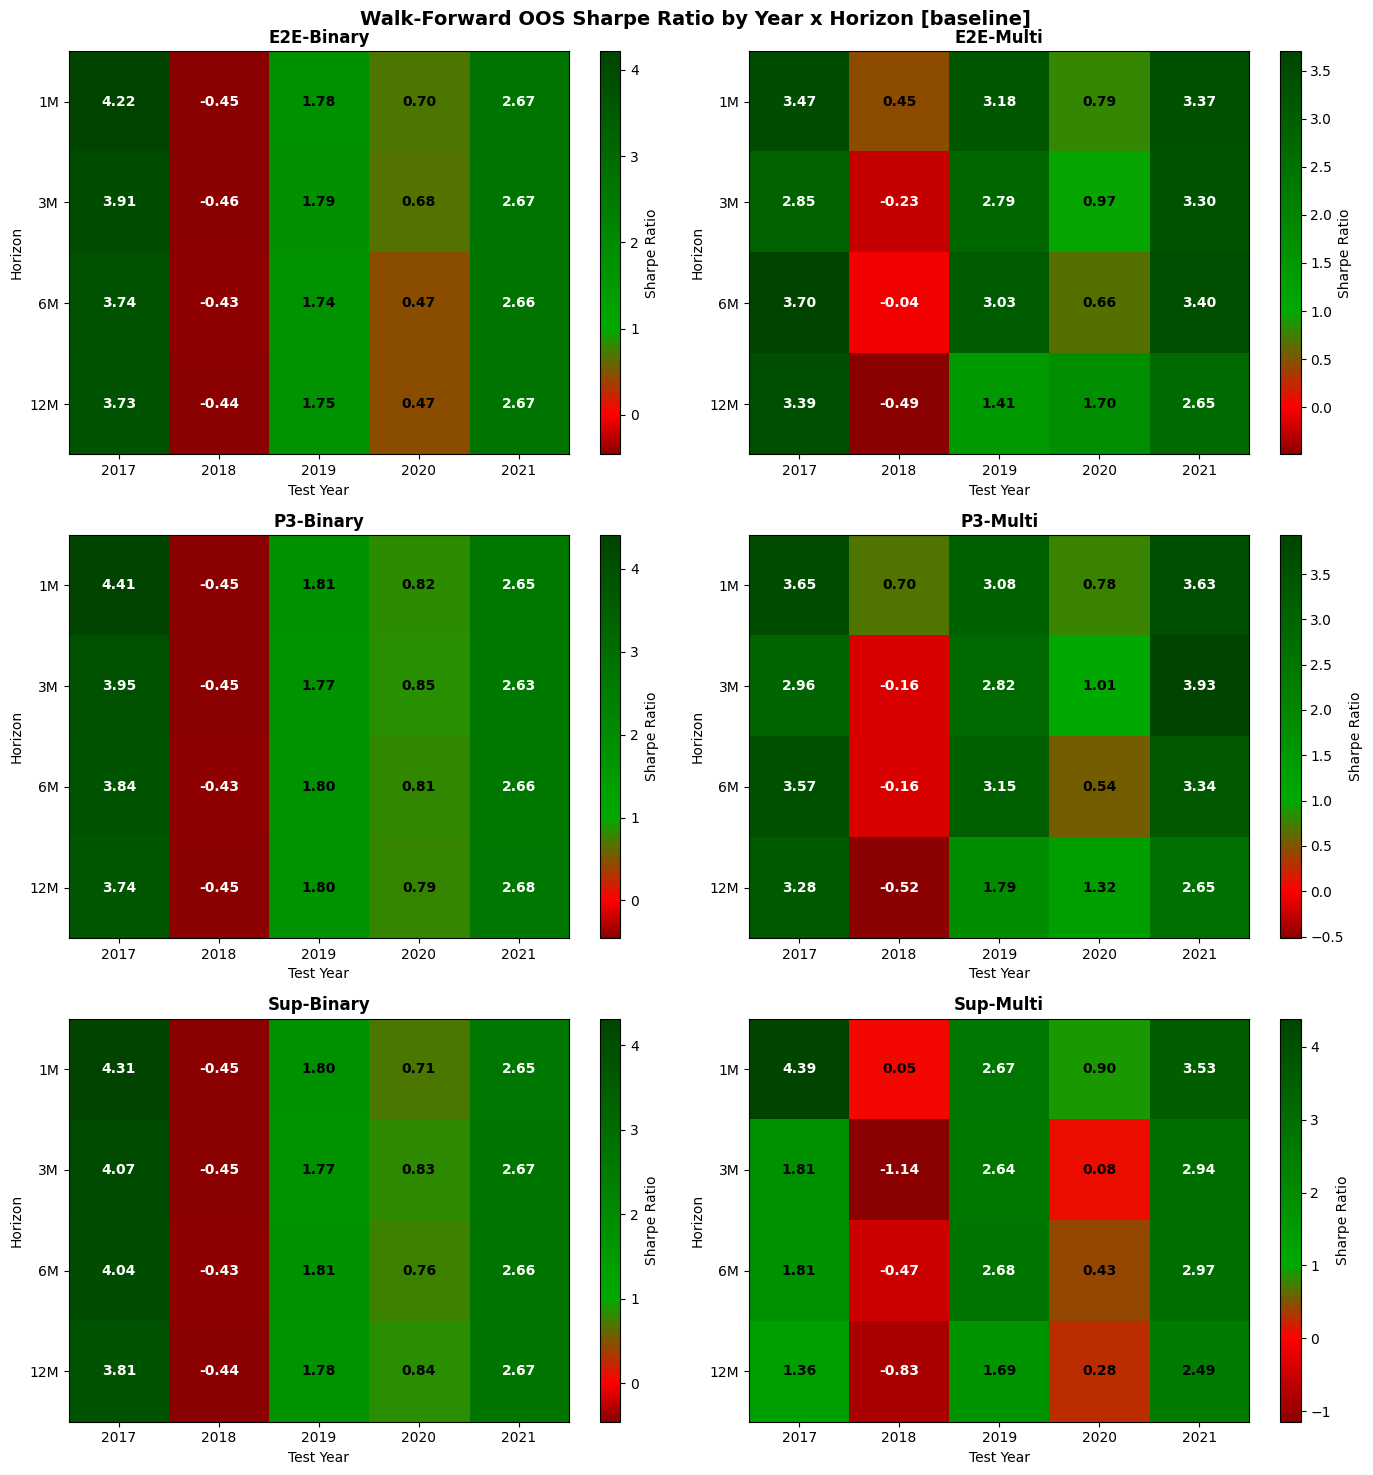

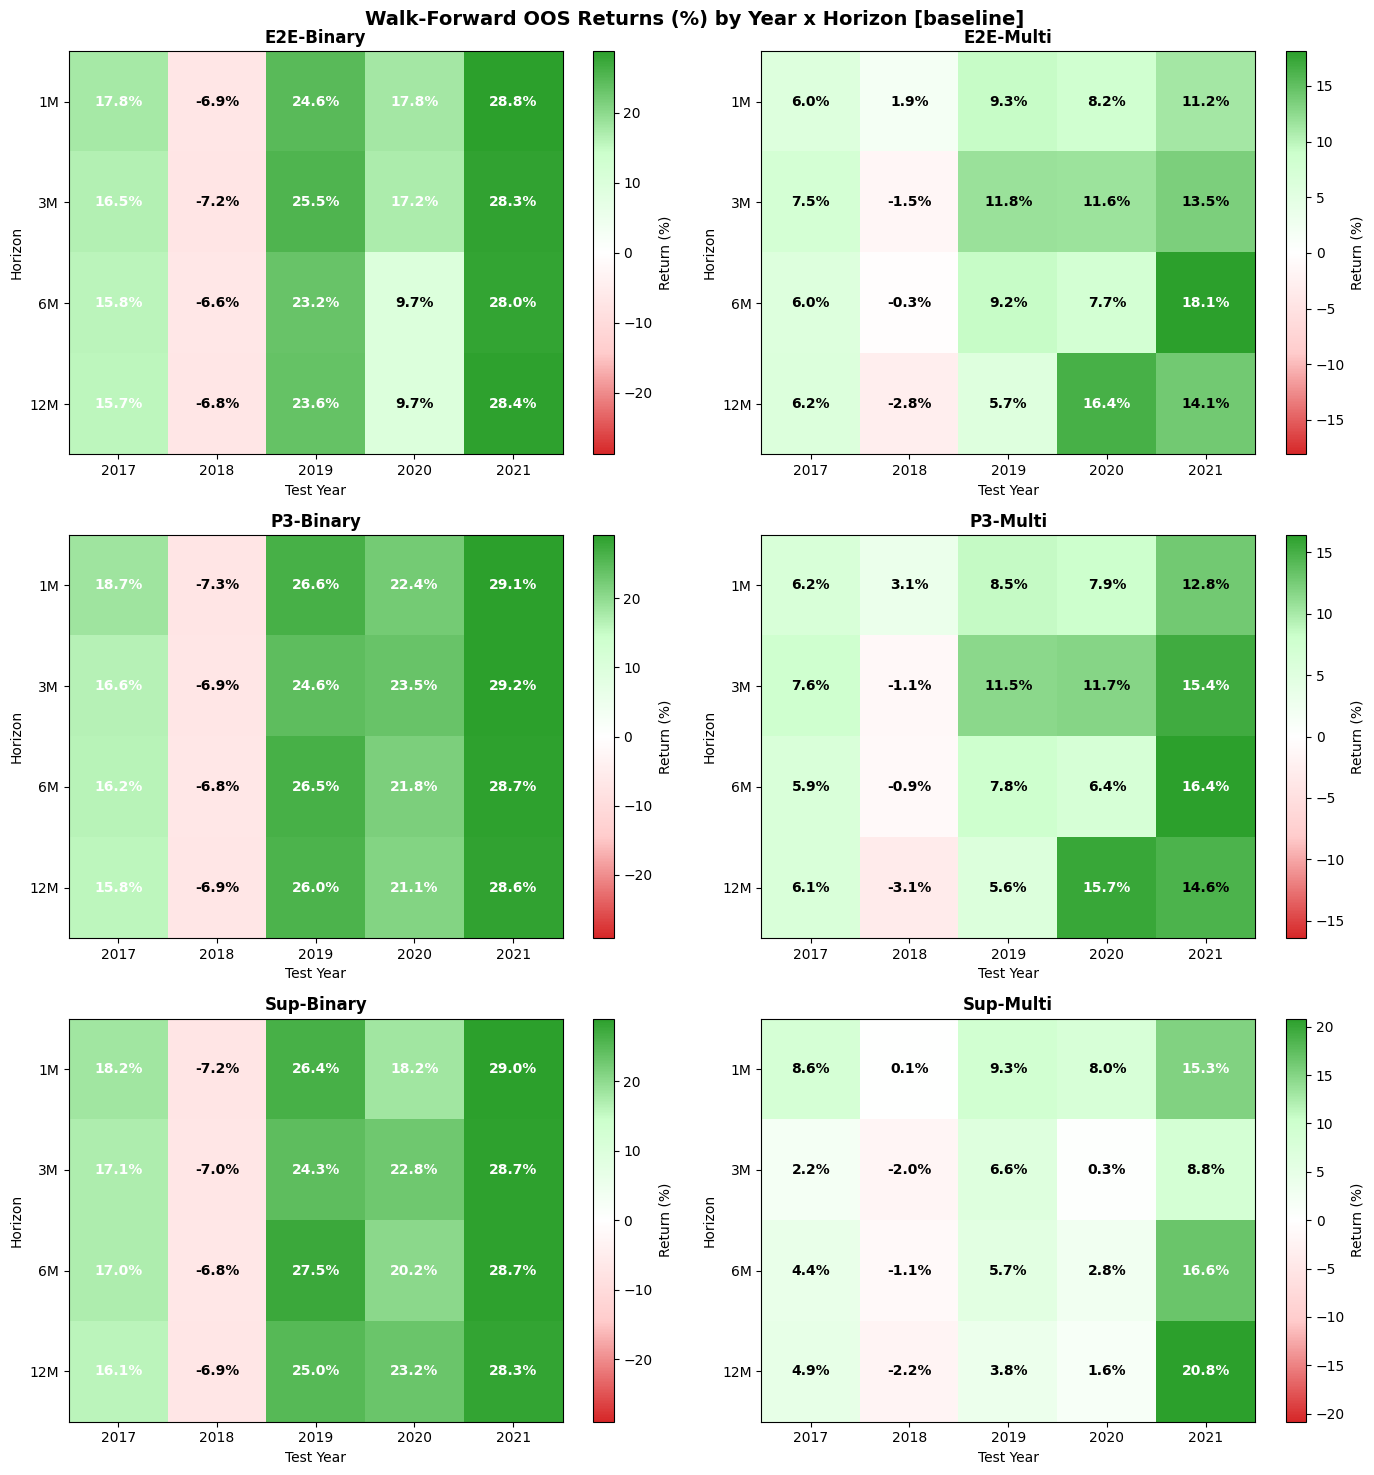

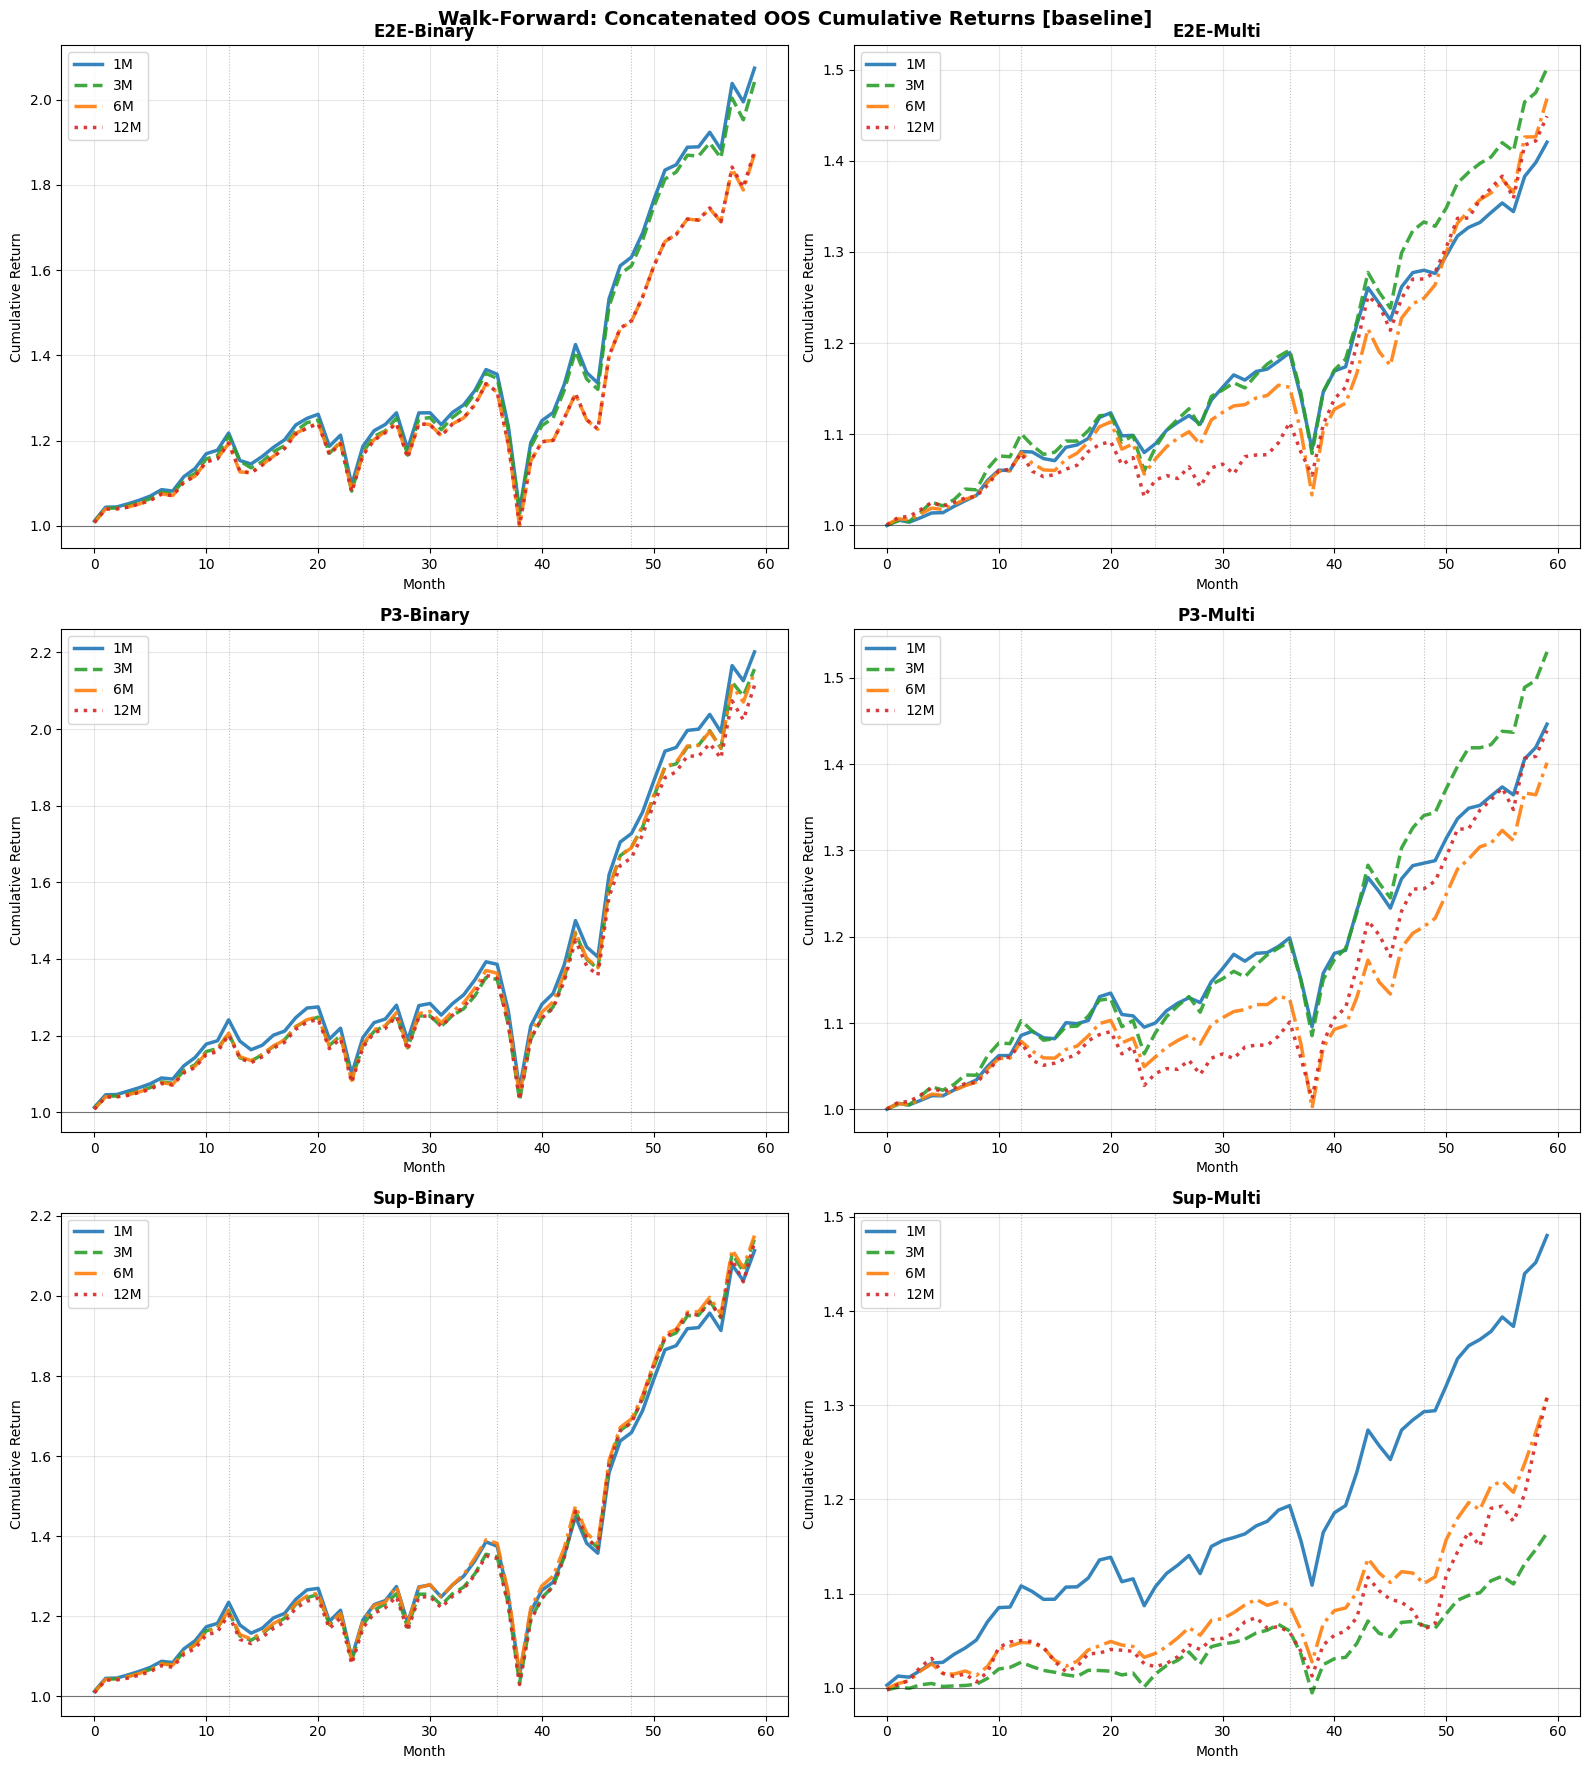

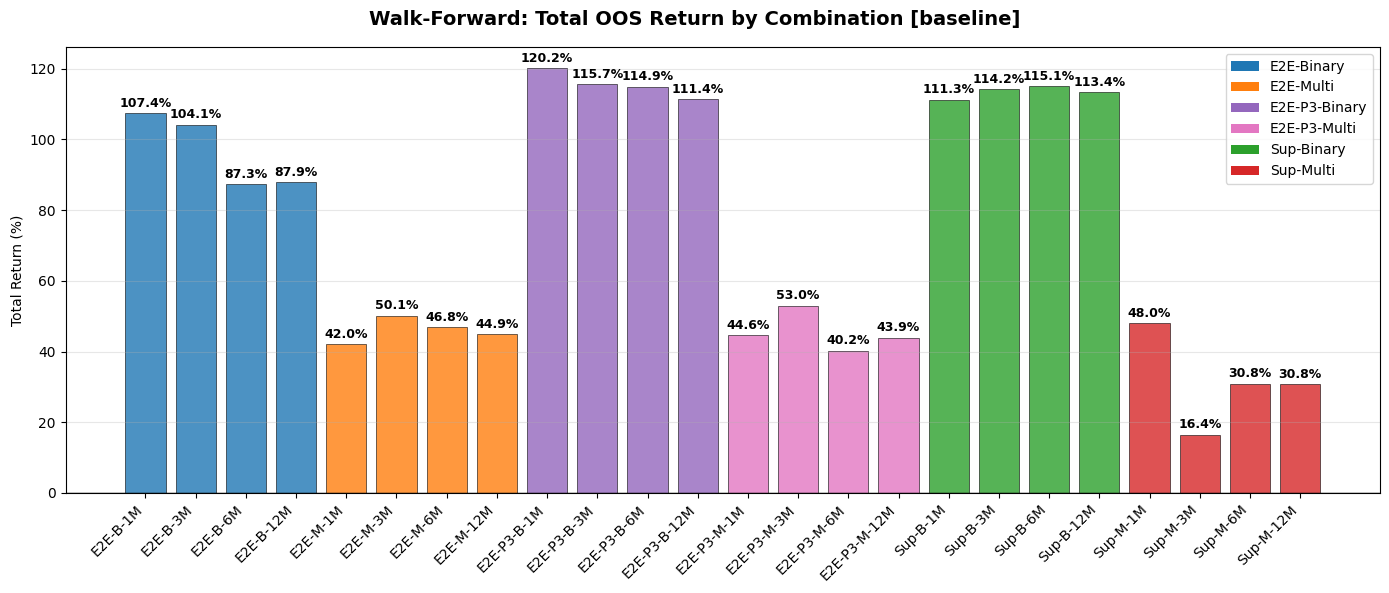

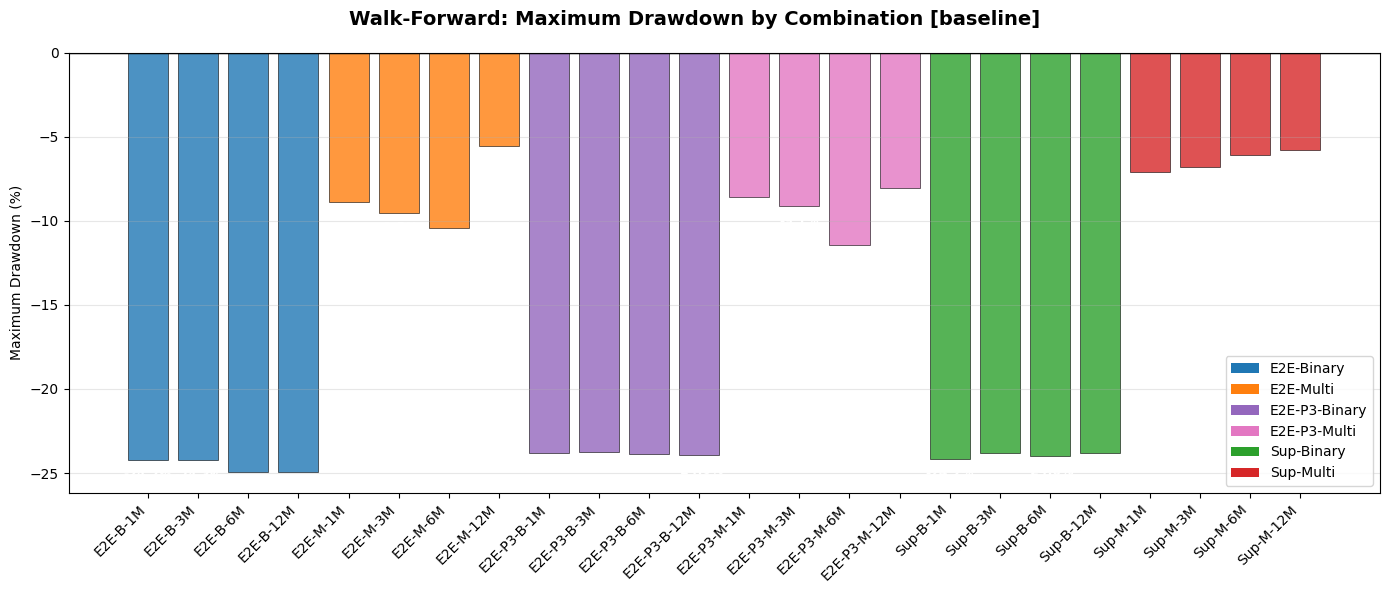


WALK-FORWARD SUMMARY BY YEAR [baseline]

Combination                    2017      2018      2019      2020      2021       TOTAL      MAX DD
---------------------------------------------------------------------------------------------------
E2E-B-1M                      +17.8%      -6.9%     +24.6%     +17.8%     +28.8%      +107.4%       -24.2%
E2E-B-3M                      +16.5%      -7.2%     +25.5%     +17.2%     +28.3%      +104.1%       -24.3%
E2E-B-6M                      +15.8%      -6.6%     +23.2%      +9.7%     +28.0%       +87.3%       -24.9%
E2E-B-12M                     +15.7%      -6.8%     +23.6%      +9.7%     +28.4%       +87.9%       -24.9%
E2E-M-1M                       +6.0%      +1.9%      +9.3%      +8.2%     +11.2%       +42.0%        -8.9%
E2E-M-3M                       +7.5%      -1.5%     +11.8%     +11.6%     +13.5%       +50.1%        -9.5%
E2E-M-6M                       +6.0%      -0.3%      +9.2%      +7.7%     +18.1%       +46.8%       -10.4%
E2E-M-12M

In [8]:
# ============================================================
# WALK-FORWARD VISUALIZATIONS
# ============================================================

# Reload modules if needed
reload_all()

# Import year summary table
from visualization.walk_forward_plots import print_year_summary_table

# Get unique configs from results
configs_in_results = list(set(
    key[3] if len(key) == 4 else "baseline"
    for key in all_wf_results.keys()
))
configs_in_results.sort(key=lambda x: ["baseline", "fs", "hpt", "fs+hpt"].index(x) if x in ["baseline", "fs", "hpt", "fs+hpt"] else 99)

print(f"Configs in results: {configs_in_results}")
print(f"\n{'='*80}")
print("WALK-FORWARD RESULTS")
print(f"{'='*80}")

# Show all configs together (new multi-config visualization)
if len(configs_in_results) > 1:
    # Use config_filter=None to show all configs integrated in charts
    plot_all_walk_forward(all_wf_results, config_filter=None)
    print_year_summary_table(all_wf_results, config_filter=None)
else:
    # Single config - use that specific config
    plot_all_walk_forward(all_wf_results, config_filter=configs_in_results[0])
    print_year_summary_table(all_wf_results, config_filter=configs_in_results[0])

---
## STEP 2: Train Final Models (All 24 Combinations)

Train a single model on **all data except holdout** for each combination.

The holdout period is determined by the actual data range (last N years of available targets).

In [9]:
# ============================================================
# STEP 2: TRAIN FINAL MODELS
# ============================================================

evaluator.run_step2_final_models()
all_final_models = evaluator.final_models

print(f"\n{'=' * 80}")
print(f"STEP 2 COMPLETE: {sum(1 for v in all_final_models.values() if v is not None)}/16 models trained")
print("=" * 80)


STEP 2: TRAINING FINAL MODELS
Training period: 2000-01-01 to 2022-12-31
Configs: ['baseline']
Training 24 combinations (24 base × 1 configs)...


--- Config: baseline ---
[1/24] Training E2E + Binary @ 1M [baseline]
  -> Model trained successfully
[2/24] Training E2E + Binary @ 3M [baseline]
  -> Model trained successfully
[3/24] Training E2E + Binary @ 6M [baseline]
  -> Model trained successfully
[4/24] Training E2E + Binary @ 12M [baseline]
  -> Model trained successfully
[5/24] Training E2E + Multi @ 1M [baseline]
  -> Model trained successfully
[6/24] Training E2E + Multi @ 3M [baseline]
  -> Model trained successfully
[7/24] Training E2E + Multi @ 6M [baseline]
  -> Model trained successfully
[8/24] Training E2E + Multi @ 12M [baseline]
  -> Model trained successfully
[9/24] Training E2E-P3 + Binary @ 1M [baseline]
  -> Model trained successfully
[10/24] Training E2E-P3 + Binary @ 3M [baseline]
  -> Model trained successfully
[11/24] Training E2E-P3 + Binary @ 6M [baseline]
  ->

---
## STEP 3: Holdout Evaluation (All 24 Combinations)

Compare **Final Model** vs **Fair Ensemble** vs **WF Ensemble** on the holdout period:

| Model Type | Description | Data Used |
|------------|-------------|-----------|
| **Final** | Single model (seed=999) | 2000-2021 (full) |
| **Fair Ensemble** | 5 models averaged (seeds 42,142,...) | 2000-2021 (full) |
| **WF Ensemble** | N walk-forward models averaged | 2000-2014 to 2000-2020 (less data) |

**Why Fair Ensemble?**
- WF Ensemble has a **data quantity bias**: each model sees different amounts of data
- Fair Ensemble uses **same data, different seeds**: isolates pure ensemble effect
- Comparison: Final vs Fair Ensemble = pure ensemble effect (no data confound)

In [10]:
# ============================================================
# STEP 3: HOLDOUT EVALUATION (with Fair Ensemble)
# ============================================================

evaluator.run_step3_holdout()
all_holdout_results = evaluator.holdout_results

# Print holdout summary
holdout_summary = evaluator._build_holdout_summary()
print("\n" + "=" * 130)
print("HOLDOUT RESULTS SUMMARY (Final vs Fair Ensemble vs WF Ensemble)")
print("=" * 130)
print(f"\n{'Strategy':<8} {'Alloc':<7} {'H':<4} {'Config':<10} {'Type':<14} {'Sharpe':>10} {'IC':>10} {'MaxDD':>10} {'Score':>8} {'Rank':>6}")
print("-" * 110)

for _, row in holdout_summary.iterrows():
    config_name = row.get('config', 'baseline')
    print(f"{row['strategy']:<8} {row['allocation']:<7} {row['horizon']}M{'':<2} {config_name:<10} "
          f"{row['model_type']:<14} {row['sharpe']:>+10.4f} {row['ic']:>+10.4f} "
          f"{row['maxdd']:>+10.4f} {row['score']:>8.4f} {int(row['rank']):>6}")

print("=" * 130)

# Winner summary using centralized analysis function
print_model_comparison_summary(holdout_summary)

print("=" * 130)


STEP 3: HOLDOUT EVALUATION
Training Fair Ensemble (5 models) + evaluating on holdout
Configs: ['baseline']
Holdout start: 2022-01-01


--- Config: baseline ---

[1/24] E2E + Binary @ 1M [baseline]

  Evaluating final model on holdout (2022-2024)...
  Holdout samples: 23
  Sharpe: +0.14
  IC: -8.3%
  Total Return: +1.5%
  Training Fair Ensemble (5 models)...

  Ensemble evaluation (5 models) on holdout (2022-2024)...
  Holdout samples: 23
  fair_ensemble Sharpe: +0.17
  fair_ensemble IC: -1.0%
  fair_ensemble Total Return: +2.9%

  Ensemble evaluation (5 models) on holdout (2022-2024)...
  Holdout samples: 23
  wf_ensemble Sharpe: +0.20
  wf_ensemble IC: +1.9%
  wf_ensemble Total Return: +4.0%

[2/24] E2E + Binary @ 3M [baseline]

  Evaluating final model on holdout (2022-2024)...
  Holdout samples: 21
  Sharpe: +0.03
  IC: +17.3%
  Total Return: -2.1%
  Training Fair Ensemble (5 models)...

  Ensemble evaluation (5 models) on holdout (2022-2024)...
  Holdout samples: 21
  fair_ensembl

All modules reloaded successfully!
Configs in results: ['baseline']

HOLDOUT RESULTS


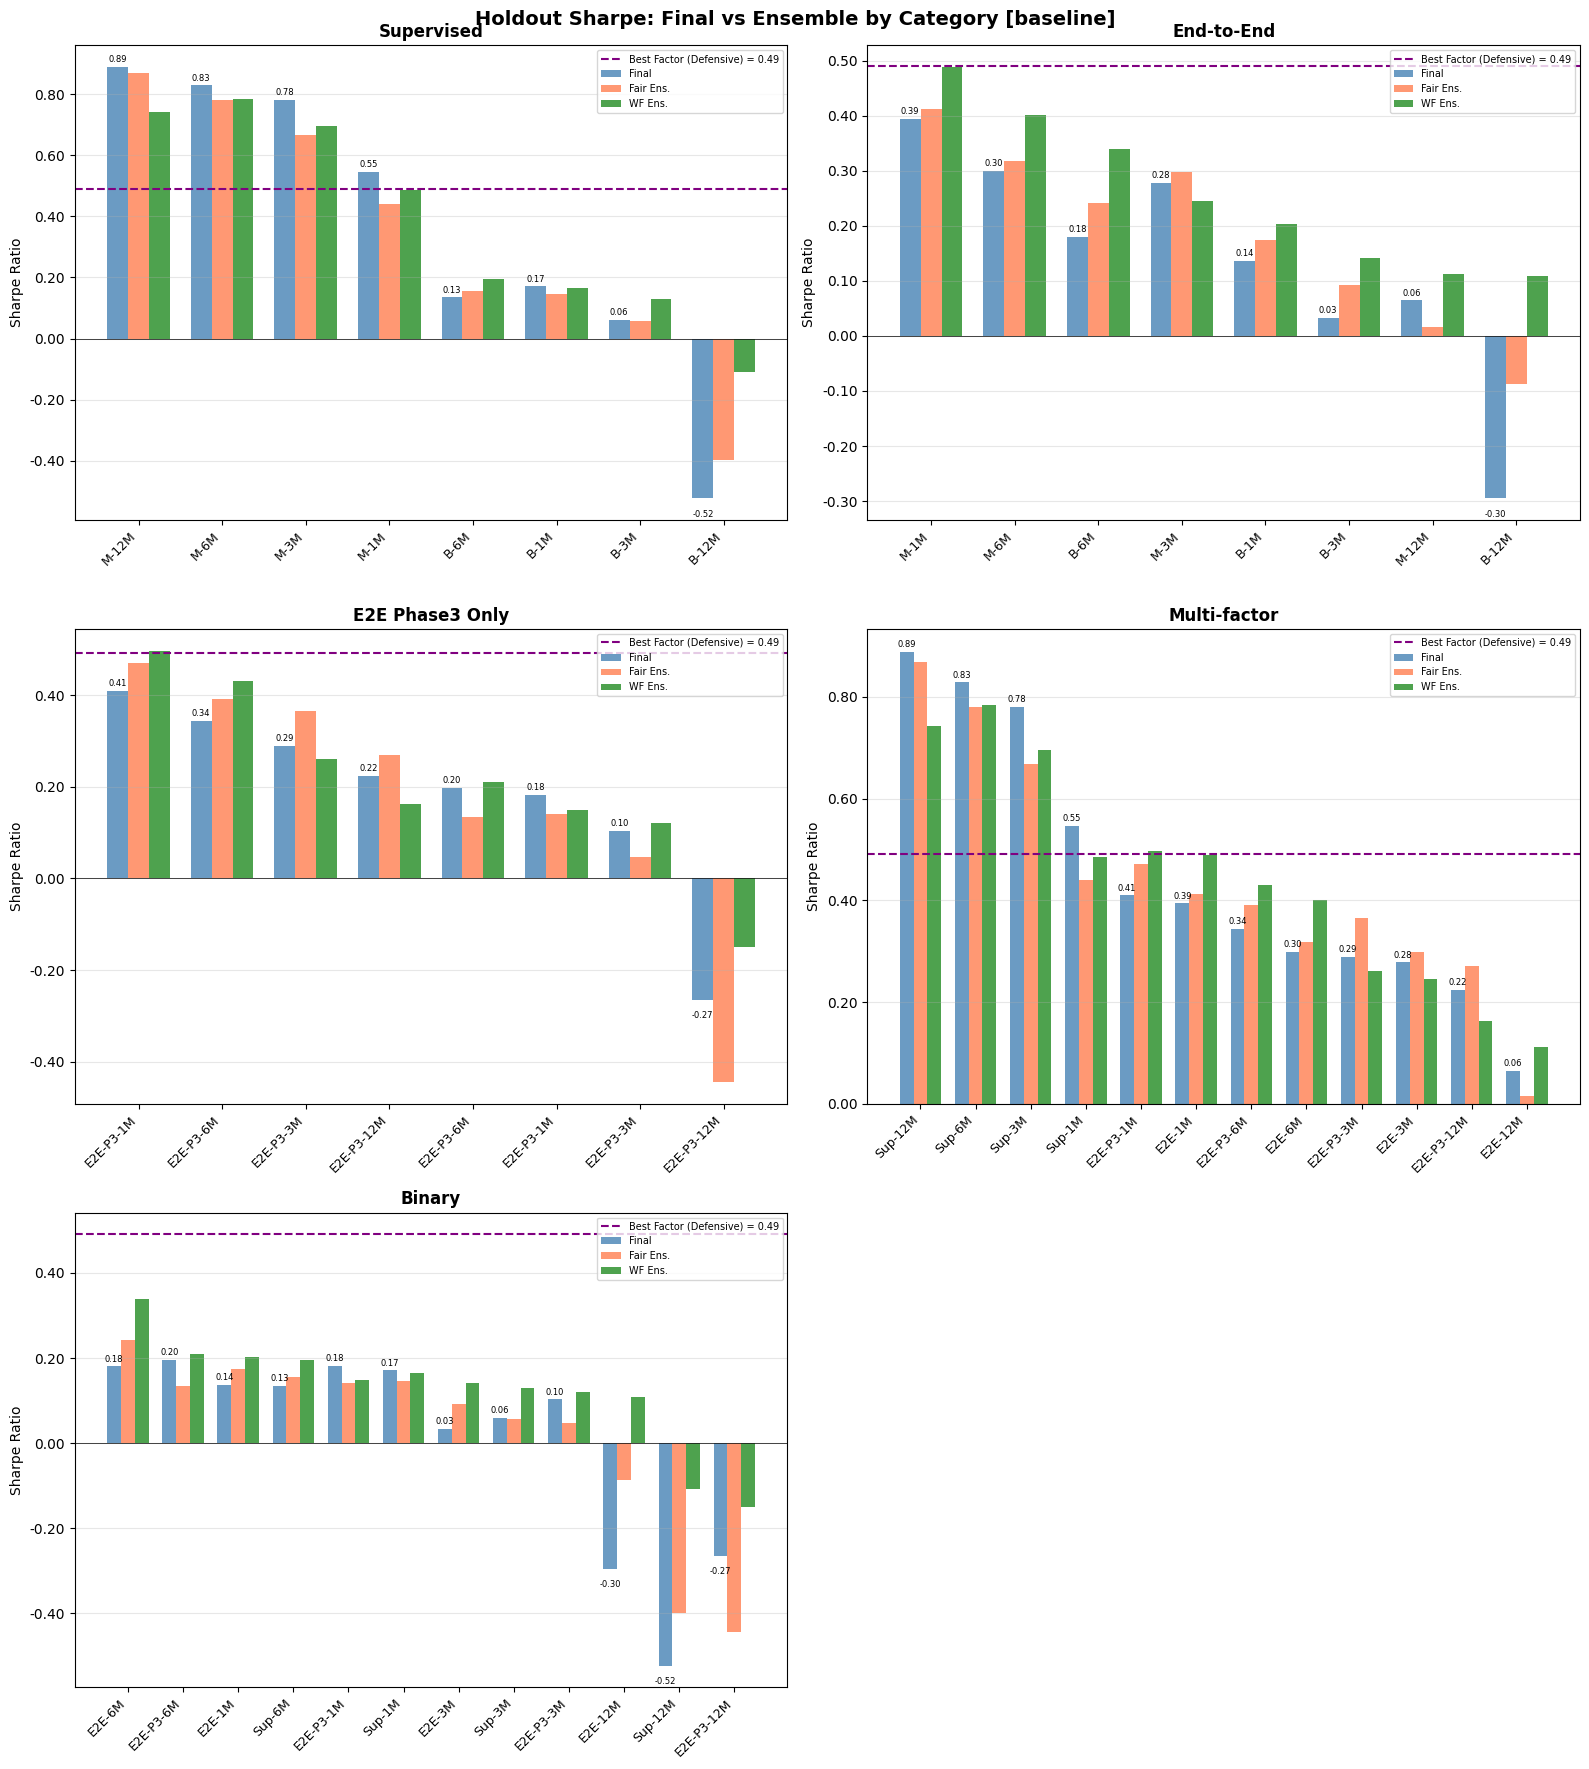

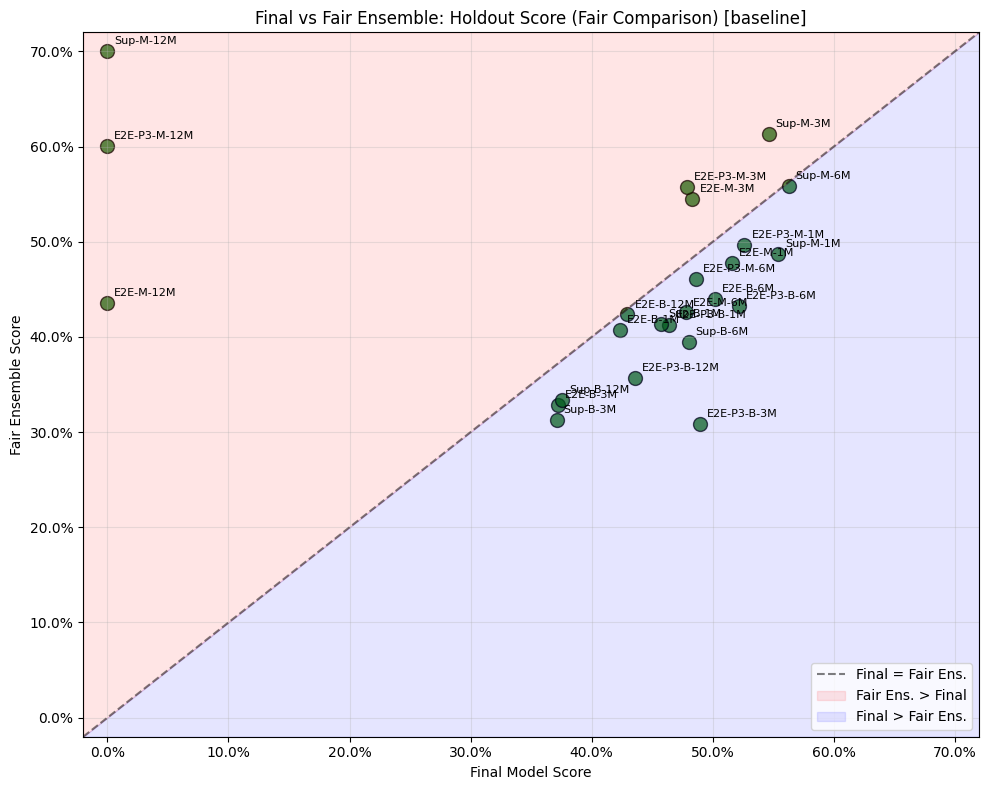

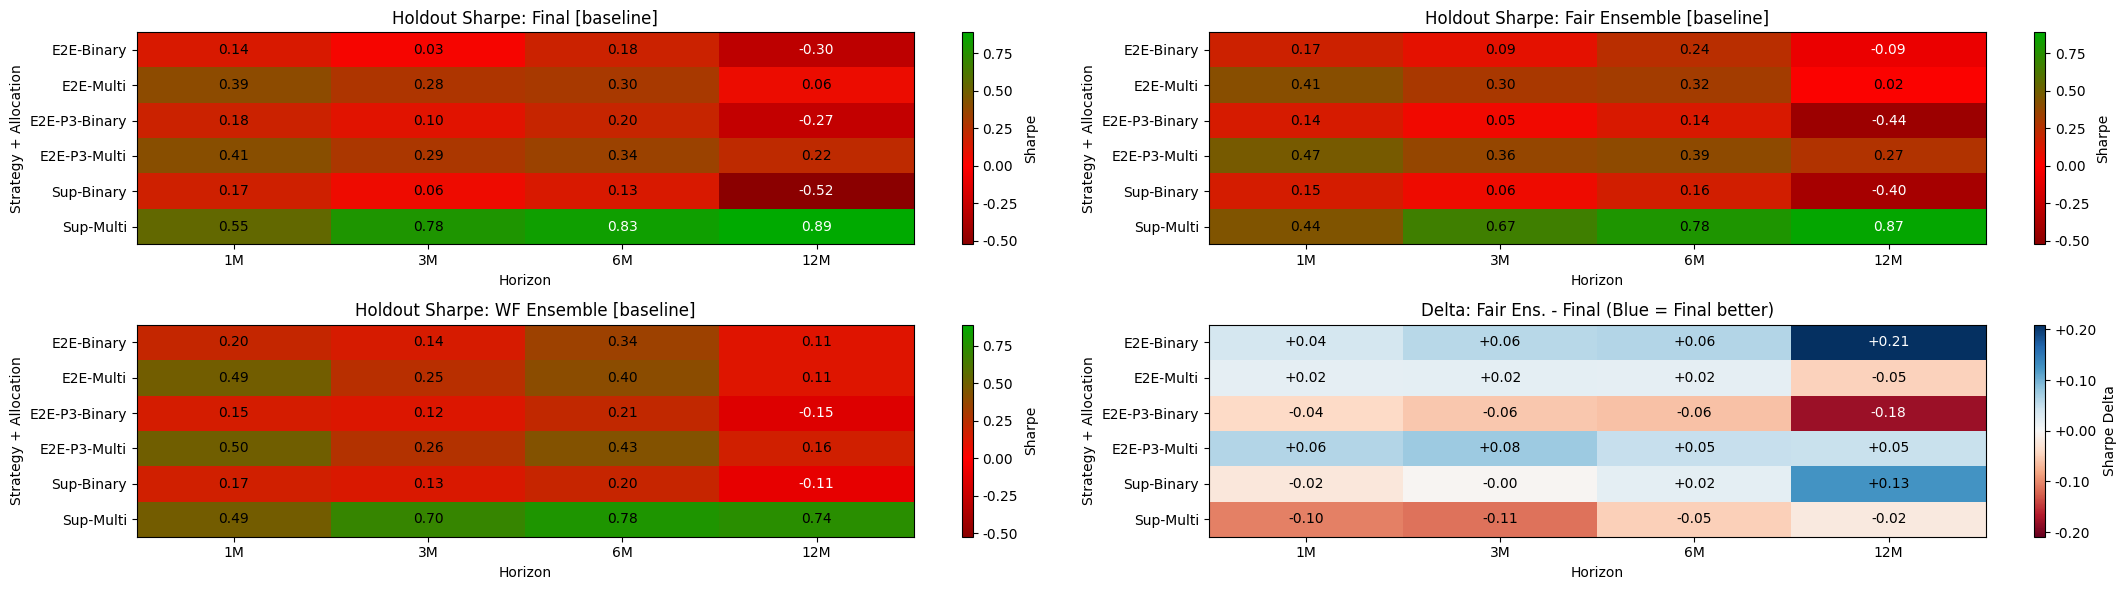

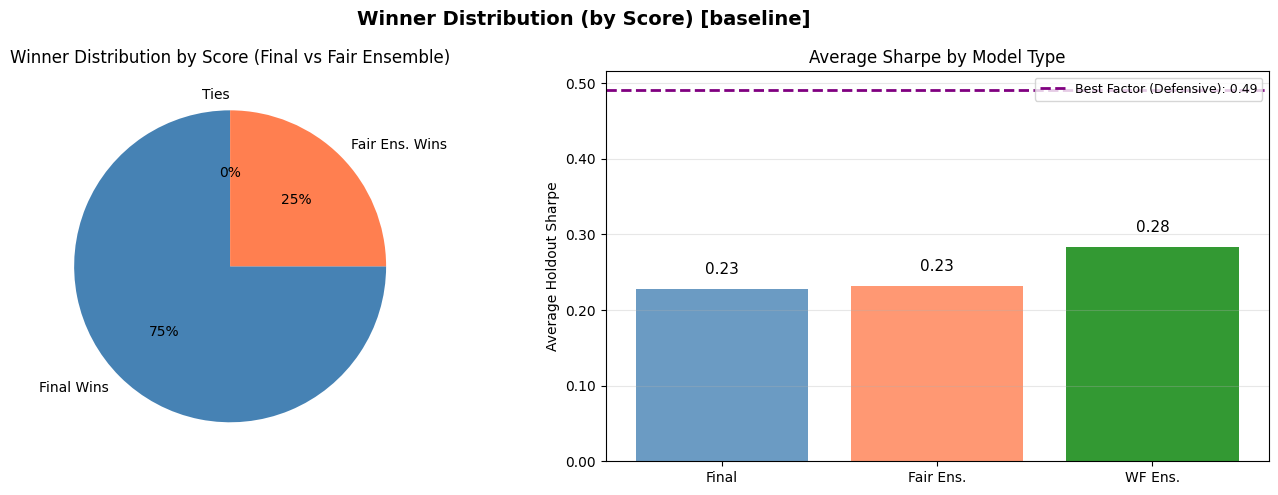

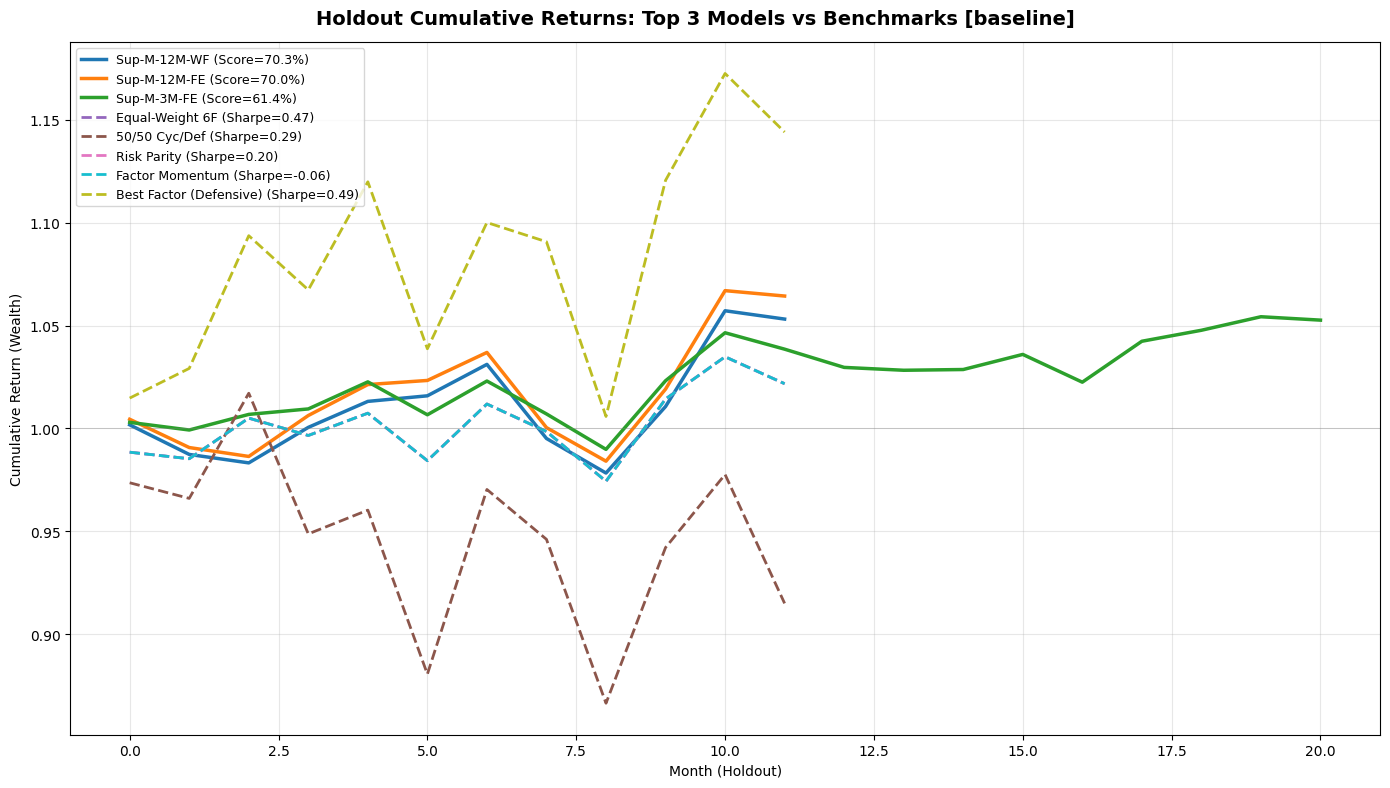


COMPLETE HOLDOUT RESULTS (with Composite Score) [baseline]

Label              Strategy Alloc   H    Type           Sharpe       IC      MaxDD     Return    Score   Rank
------------------------------------------------------------------------------------------------------------------------
Sup-M-12M-WF       Sup      Multi   12M   WF Ens.         +0.74    +51.3%      -5.1%      +5.3%    60.3%      1
Sup-M-12M-FE       Sup      Multi   12M   Fair Ens.       +0.87    +41.2%      -5.1%      +6.4%    60.0%      2
Sup-M-3M-FE        Sup      Multi   3M   Fair Ens.       +0.67    +14.8%      -3.2%      +5.3%    51.4%      3
E2E-P3-M-12M-WF    E2E-P3   Multi   12M   WF Ens.         +0.16    +50.2%      -4.4%      +1.0%    50.4%      4
E2E-P3-M-12M-FE    E2E-P3   Multi   12M   Fair Ens.       +0.27    +40.6%      -4.2%      +1.8%    50.1%      5
E2E-M-12M-WF       E2E      Multi   12M   WF Ens.         +0.11    +51.8%      -4.3%      +0.6%    50.0%      6
Sup-M-3M-WF        Sup      Multi   3

In [11]:
# ============================================================
# HOLDOUT VISUALIZATIONS
# ============================================================

# Reload modules if needed (uncomment if you modified source code)
reload_all()

# Import holdout summary
from visualization.holdout_plots import print_holdout_summary_table

# Compute benchmarks for the holdout period
holdout_start = pd.Timestamp("2022-01-01")
benchmarks = compute_all_benchmarks(factor_data, start_date=holdout_start)

# Get unique configs from results
configs_in_results = list(set(
    key[3] if len(key) == 4 else "baseline"
    for key in all_holdout_results.keys()
))
configs_in_results.sort(key=lambda x: ["baseline", "fs", "hpt", "fs+hpt"].index(x) if x in ["baseline", "fs", "hpt", "fs+hpt"] else 99)

print(f"Configs in results: {configs_in_results}")
print(f"\n{'='*80}")
print("HOLDOUT RESULTS")
print(f"{'='*80}")

# Show all configs together (new multi-config visualization)
if len(configs_in_results) > 1:
    # Use config_filter=None to show all configs integrated in charts
    plot_all_holdout(
        all_holdout_results,
        horizons=[1, 3, 6, 12],
        compute_score_fn=compute_composite_score,
        benchmarks=benchmarks,
        config_filter=None,
    )
    print_holdout_summary_table(all_holdout_results, compute_score_fn=compute_composite_score, config_filter=None)
else:
    # Single config - use that specific config
    plot_all_holdout(
        all_holdout_results,
        horizons=[1, 3, 6, 12],
        compute_score_fn=compute_composite_score,
        benchmarks=benchmarks,
        config_filter=configs_in_results[0],
    )
    print_holdout_summary_table(all_holdout_results, compute_score_fn=compute_composite_score, config_filter=configs_in_results[0])

# ============================================================
# BEST MODELS vs BENCHMARKS (using centralized analysis function)
# ============================================================

print_best_models_table(all_holdout_results, benchmarks)

# ============================================================
# EXPORT RESULTS FOR DASHBOARD
# ============================================================

# Add dashboard to path
if str(project_root / "dashboard") not in sys.path:
    sys.path.insert(0, str(project_root))

# Force reload the export module to pick up new function
import importlib
import dashboard.export_results
importlib.reload(dashboard.export_results)

from dashboard.export_results import (
    export_holdout_results_to_cache,
    export_walk_forward_results_to_cache,
    export_benchmarks_to_cache,
)

# Export holdout results (includes monthly returns)
export_holdout_results_to_cache(all_holdout_results)

# Export walk-forward results
export_walk_forward_results_to_cache(all_wf_results)

# Export benchmarks (includes monthly returns for cumulative chart)
export_benchmarks_to_cache(benchmarks)

print("\nResults exported! Run the dashboard with:")
print("  cd Strategies/factor_allocation_strategy_macro")
print("  streamlit run dashboard/app.py")

In [12]:
# ============================================================
# STATISTICAL ANALYSIS (Bootstrap CIs & Significance Tests)
# ============================================================
# This cell performs rigorous statistical analysis on holdout results:
# - Bootstrap confidence intervals for Sharpe ratios (n=1000)
# - Lo (2002) significance test: Is Sharpe significantly > 0?
# - Jobson-Korkie test: Is model Sharpe significantly > benchmark?

# Reload to ensure latest code
reload_all()

# Run statistical analysis on top models vs best benchmark
print_statistical_analysis(
    holdout_results=all_holdout_results,
    benchmarks=benchmarks,
    confidence_level=0.95,
    n_bootstrap=1000,
)

All modules reloaded successfully!

STATISTICAL ANALYSIS (Bootstrap CIs & Significance Tests)
Bootstrap samples: 1000, Confidence level: 95%
------------------------------------------------------------------------------------------

Model                                 Sharpe             95% CI    p-value   Signif
------------------------------------------------------------------------------------------
Sup-M-12M-WF                          +0.710   [-1.325, +2.853]     0.0502    Yes *
Sup-M-12M-FE                          +0.831   [-1.269, +3.124]     0.0305   Yes **
P3-M-12M-WF                           +0.156   [-2.302, +2.232]     0.6012       No
Significance: *** p<0.01, ** p<0.05, * p<0.10
